In [4]:
import pandas as pd
import numpy as np
import os
np.random.seed(42)

### A) Expected data format for SSAML code.  
Make sure you have a .csv file with the following columns and row formats. The format differs for non-survival-analysis and survival-analysis tasks. Within runner_power.sh you will find a boolean parameter survivalTF to be set (True for survival analysis, False for non-survival analysis), and a boolean parameter peopleTF (True for patient-level analysis and False for event-level analysis). This notebook is therefore a preprocessing guide/tutorial to re-format existing data to make it ready for SSAML algorithm and the runner_power.sh code. The analysis method is not determined here but with the aforementioned parameters in runner_power.sh.

1. 'regular', non-survival analysis model.  
    columns:  
    -- ID: unique patient identifier (integers)  
    -- event: ground truth / label (integers)  
    -- p: model output, event probability  

   rows are data observations (i.e. one row per event/patient)
   
2. survival analysis model.  
    columns:   
    -- ID: unique patient identifier (integers)  
    -- C: censhorhip information (i.e. 1 for censored, 0 for not censored)  
    -- z is the z-score value, a covariate for Cox proportional hazard.
    -- T: time to event  

   rows are data observations (i.e. one row per event/patient)

### B) sample datasets, as presented in the paper

here, we present the format for three distinct tasks, as presented in the paper.

#### B.1) seizure risk prediction ('seizure tracker (ST) data')

In [2]:
# c = pd.read_csv(big_file,sep=',',names=['ID','szTF','AI','RMR'])
# uids = pd.unique(c.ID)
# c.rename(columns={'szTF':'event'},inplace=True)
# c.rename(columns={'AI':'p'},inplace=True)
# peopleTF=True
# survivalTF=False

In [3]:
data = pd.DataFrame(columns=['ID', 'event', 'p'])
data['ID'] = np.arange(100)
data['event'] = np.random.randint(0, high=2, size=data.shape[0]) # binary outcome, high excluded
data['p'] = np.random.rand(data.shape[0]) # model output, probability values between 0 and 1

In [4]:
print(f'data shape: {data.shape}')
print(f'events contained: \n{data.event.value_counts()}')
data.head()

data shape: (100, 3)
events contained: 
1    56
0    44
Name: event, dtype: int64


,ID,event,p
0,0,0,0.969585
1,1,1,0.775133
2,2,0,0.939499
3,3,0,0.894827
4,4,0,0.597900


In [5]:
data.to_csv('sample_data_st.csv', index=False)

#### B.2) covid hospitalization risk prediciton ('COVA dataset')

In [6]:
data['ID'] = np.arange(100)
data['event'] = np.random.randint(0, high=2, size=data.shape[0]) # binary outcome, high excluded
data['p'] = np.random.rand(data.shape[0]) # model output, probability values between 0 and 1

In [22]:

data_raw = pd.read_csv('COVA-FAKE.csv', sep=',')
data = pd.DataFrame()
data['ID'] = np.array(range(data_raw.shape[0]))
event_categories = ['Prob-dead','Prob-ICU-MV','Prob-Hosp']
data['p'] = (data_raw[event_categories[0]] + data_raw[event_categories[1]] + data_raw[event_categories[2]])/100
data['event'] = 0.0 + (data_raw['actual']>0)

In [23]:
print(f'data shape: {data.shape}')
print(f'events contained: \n{data.event.value_counts()}')
data.head()

data shape: (5000, 3)
events contained: 
0.0    3131
1.0    1869
Name: event, dtype: int64


,ID,p,event
0,0,0.09342,0.0
1,1,0.93350,1.0
2,2,0.85244,0.0
3,3,0.97550,0.0
4,4,0.84995,1.0


In [24]:
data.to_csv('sample_data_cova.csv', index=False)

#### B.3) Brain age - mortality risk prediction (survival analysis)

This database file has the following columns: 'z','T','C', reflecting a z score (output of ML), T=time, and C=censored yes=1, no=0
The ID numbers were not supplied, so row number can be used to produce a sequential ID number here in preprocessing.

In [10]:
# c = pd.read_csv(big_file,sep=',')
# uids =  uids = np.array(range(c.shape[0]))
# c['ID'] = uids
# peopleTF=True
# survivalTF=True

In [19]:
data = pd.DataFrame(columns=['ID','z', 'T', 'C'])
data['ID'] = np.arange(100)
data['T'] = np.random.randint(0, high=21, size=data.shape[0]) # random integer values for time to event
data['C'] = np.random.randint(0, 2, size=data.shape[0]) # random binary censorship information Yes/No
data['z'] = np.random.normal(loc=0, scale=1, size=data.shape[0]) # random z-scored confounding variable.


In [12]:
print(f'data shape: {data.shape}')
print(f'events contained: \n{data.C.value_counts()}')
data.head()

data shape: (100, 4)
events contained: 
0    59
1    41
Name: C, dtype: int64


,ID,T,C,z
0,0,12,0,0.055572
1,1,19,0,0.060233
2,2,14,1,-1.439462
3,3,2,1,-0.383488
4,4,7,0,0.886202


In [13]:
data.to_csv('sample_data_bai_mortality.csv', index=False)

Loading smallZ...
       Slope  C-index    CIL       N
0        0.0    0.514  2.965   100.0
1        0.0    0.496  2.808   100.0
2        0.0    0.562  2.576   100.0
3        0.0    0.430  2.581   100.0
4        0.0    0.539  2.803   100.0
...      ...      ...    ...     ...
29995    0.0    0.480  2.592  1000.0
29996    0.0    0.484  2.830  1000.0
29997    0.0    0.452  2.778  1000.0
29998    0.0    0.490  2.729  1000.0
29999    0.0    0.472  2.633  1000.0

[30000 rows x 4 columns]
plotting...


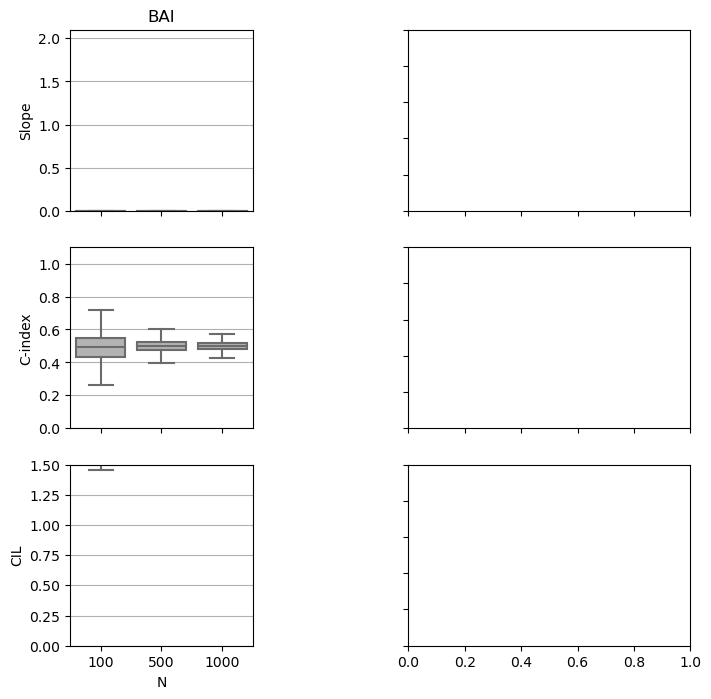

saving...


In [42]:
## After you rrun runner_power with your modified parameters, you will get output files.
## if you had enabled "doEXTRA=True" in power.py, then you can plot the zing files as
## as follows or from modifying the make-power-pix.py

import matplotlib

#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import os
import sys
import time

# CONSTANTS
# put whatever your local directory is that has your files from SSAML
mydir = '/Users/danisized/Documents/GitHub/SSAML/OUTcovaFAKE/'
# Note, the numLIST numbers here are hard coded for the number of patients/events we tested. 
# change to whatever you like here
numLIST = [100,500,1000]

# FUNCTION DEFINITIONS
def getZING(prefixN,middleOne,numLIST):
  # load up the ZING files and compose a pandas dataframe from it
  print('Loading %s...' % prefixN)
  
  for howmany in numLIST:
    fn = prefixN + str(howmany).zfill(4) + '.csv'
    dat = pd.read_csv(fn,sep=',',header=None)
    dat.columns =['Slope',middleOne,'CIL']
    dat['N'] = dat.Slope*0 + howmany
    if howmany == numLIST[0]:
      bigD = dat
    else:
      bigD = bigD.append(dat,ignore_index=True)
  return bigD

def plotC(dat,numLIST,fig,ax,tName):
  #plot the column number colNum
  C=(.7,.7,.7)
  colNum=1
  plt.subplot(3,3,colNum)
  ax[0,colNum-1] = sns.boxplot(x="N", y="Slope",fliersize=0,color=C, data=dat)
  plt.grid(True,axis='y')
  plt.ylim(0,2.1)
  plt.xlabel('')
  plt.title(tName)

  plt.subplot(3,3,3+colNum)
  ax[1,colNum-1] = sns.boxplot(x="N", y="C-index",fliersize=0,color=C, data=dat)
  plt.grid(True,axis='y')
  plt.ylim(0,1.1)
  plt.xlabel('')

  plt.subplot(3,3,6+colNum)
  ax[2,colNum-1] = sns.boxplot(x="N", y="CIL",fliersize=0,color=C,data=dat)
  plt.grid(True,axis='y')
  plt.ylim(0,1.5)

  ax[0,colNum-1].axes.xaxis.set_ticklabels([])
  ax[1,colNum-1].axes.xaxis.set_ticklabels([])
  ax[2,colNum-1].axes.xaxis.set_ticklabels(numLIST)
  if colNum>1:
    ax[0,colNum-1].axes.yaxis.set_ticklabels([])   
    ax[1,colNum-1].axes.yaxis.set_ticklabels([])   
    ax[2,colNum-1].axes.yaxis.set_ticklabels([])   
    ax[0,colNum-1].set_ylabel('')
    ax[1,colNum-1].set_ylabel('')
    ax[2,colNum-1].set_ylabel('')

  return


# MAIN
os.chdir(mydir)

bigD = getZING('smallZ','C-index',numLIST)
print(bigD)


print('plotting...')
fig, ax = plt.subplots(3,2,sharex='col',sharey='row',figsize=(8,8))

plotC(bigD,numLIST,fig,ax,'BAI')
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.2)
plt.show()
print('saving...')
# jpeg in 300 dpi
fig.savefig('ZplotFull-v2.jpg',dpi=300)

